## Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os

In [4]:
data_dir = '/root/pneumonia_data/chest_xray'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'val', 'train']
['PNEUMONIA', 'NORMAL']


In [5]:
pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training examples for Pneumonia: ', len(pneumonia_files))
print(pneumonia_files[:5])

No. of training examples for Pneumonia:  3875
['person1112_virus_1837.jpeg', 'person258_bacteria_1215.jpeg', 'person59_bacteria_284.jpeg', 'person1320_bacteria_3340.jpeg', 'person733_bacteria_2635.jpeg']


In [6]:
normal_files = os.listdir(data_dir + "/train/NORMAL")
print('No. of training examples for Normal: ', len(normal_files))
print(normal_files[:5])

No. of training examples for Normal:  1341
['IM-0582-0001.jpeg', 'NORMAL2-IM-0508-0001.jpeg', 'IM-0644-0001.jpeg', 'IM-0607-0001.jpeg', 'IM-0695-0001.jpeg']


In [10]:
dataset = ImageFolder(data_dir + '/train',
transform = transforms.Compose([transforms.Resize(255),
transforms.CenterCrop(224), transforms.RandomHorizontalFlip(), transforms.RandomRotation(10), transforms.RandomGrayscale(), transforms.RandomAffine(translate=(0.05, 0.05), degrees=0), transforms.ToTensor()]))

In [11]:
dataset

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: /root/pneumonia_data/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ToTensor()
           )

In [12]:
img, label = dataset[0]
print(img.shape, label)
print(img)

torch.Size([3, 224, 224]) 0
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [13]:
# getting the classes
print(dataset.classes)

['NORMAL', 'PNEUMONIA']


In [17]:
# number of images for each class

train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})

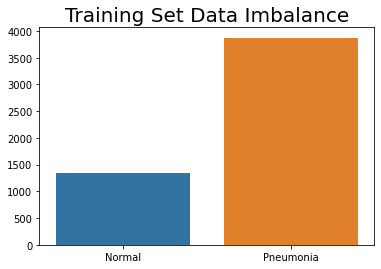

In [18]:
sns.barplot(data=train_samplesize).set_title('Training Set Data Imbalance', fontsize=20)
plt.show()

In [19]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

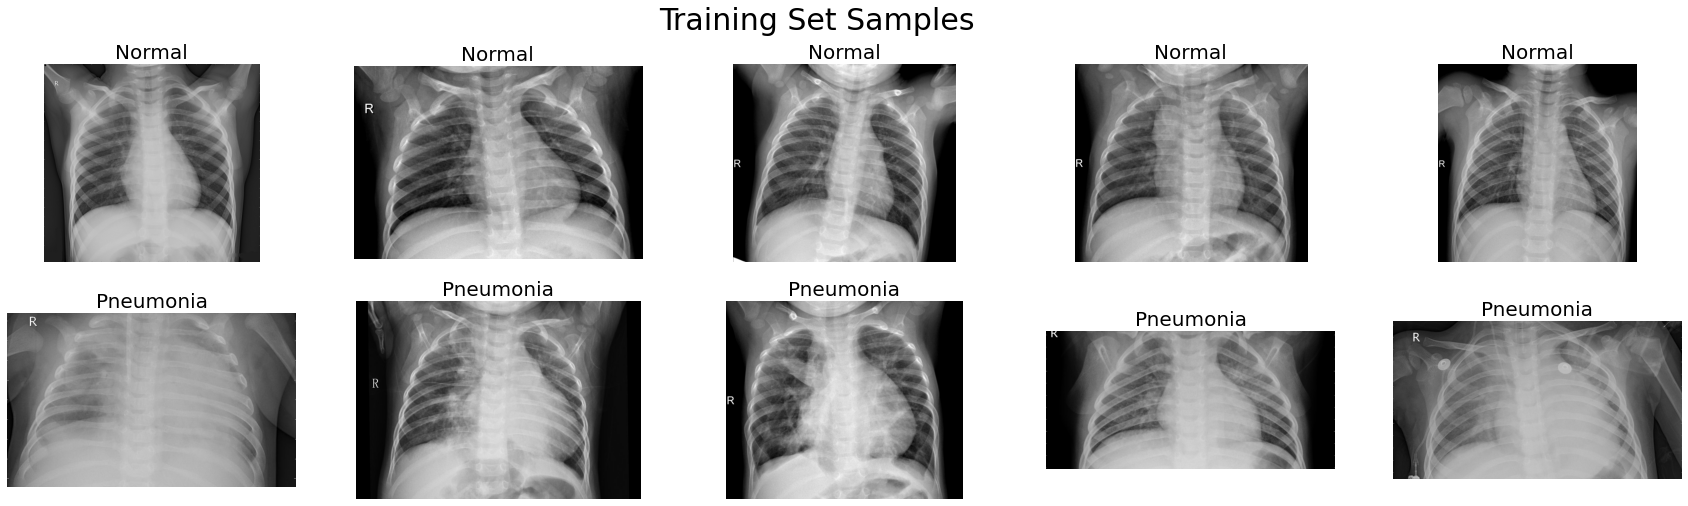

In [21]:
## Plot training samples
rand_samples = random.sample([os.path.join(data_dir+'/train/NORMAL', filename) 
                              for filename in os.listdir(data_dir+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(data_dir+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

## Preparing Train, Validation and Test Data

In [25]:
# setting the random seed
random_seed = 2021
torch.manual_seed(random_seed);

In [27]:
train_size = round(len(dataset)*0.7)
val_size = len(dataset) - train_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3651, 1565)

In [28]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

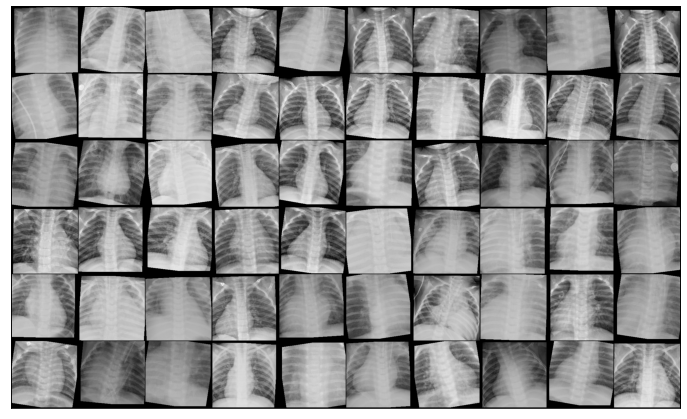

In [31]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1,2,0))
        break

show_batch(train_dl)

In [35]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
print(device)

cuda


In [37]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [38]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)